In [83]:
# Импорт всех необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ML библиотеки
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Настройки
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализаций
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print(" Все библиотеки успешно импортированы")

 Все библиотеки успешно импортированы


In [85]:
import pandas as pd
import numpy as np
import os

def load_car_data():
    """Загрузка данных о продажах автомобилей"""
    
    possible_filenames = [
        'car_sales.csv',
        'car_data.csv', 
        'automobile_data.csv',
        'cars.csv',
        'auto_sales.csv'
    ]
    
    for filename in possible_filenames:
        try:
            data = pd.read_csv(filename)
            print(f"Данные загружены из файла: {filename}")
            return data
        except FileNotFoundError:
            continue
    
    try:
        from kaggle.api.kaggle_api_extended import KaggleApi
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files("gagandeep16/car-sales", path='.', unzip=True)
        
        for filename in possible_filenames:
            try:
                data = pd.read_csv(filename)
                print("Данные загружены с Kaggle")
                return data
            except FileNotFoundError:
                continue
                
    except Exception:
        pass
    
    np.random.seed(42)
    n_samples = 200
    
    manufacturers = ['Toyota', 'Honda', 'Ford', 'BMW', 'Audi', 'Mercedes', 'Chevrolet', 'Nissan']
    vehicle_types = ['Sedan', 'SUV', 'Truck', 'Coupe', 'Hatchback']
    
    data = pd.DataFrame({
        'Manufacturer': np.random.choice(manufacturers, n_samples),
        'Model': [f'Model_{i}' for i in range(n_samples)],
        'Vehicle_type': np.random.choice(vehicle_types, n_samples),
        'Sales_in_thousands': np.random.exponential(30, n_samples) + 10,
        'Price_in_thousands': np.random.normal(25, 8, n_samples),
        'Engine_size': np.random.uniform(1.5, 4.0, n_samples),
        'Horsepower': np.random.randint(100, 300, n_samples),
        'Wheelbase': np.random.uniform(95, 115, n_samples),
        'Width': np.random.uniform(65, 75, n_samples),
        'Length': np.random.uniform(170, 190, n_samples),
        'Curb_weight': np.random.uniform(2.5, 3.5, n_samples),
        'Fuel_capacity': np.random.uniform(14, 18, n_samples),
        'Fuel_efficiency': np.random.uniform(18, 32, n_samples),
        'Power_perf_factor': np.random.uniform(40, 90, n_samples),
        'Year_resale_value': np.random.uniform(15, 25, n_samples)
    })
    
    data['Price_in_thousands'] = data['Price_in_thousands'] + data['Horsepower'] * 0.1
    data['Sales_in_thousands'] = 50 - data['Price_in_thousands'] * 0.5 + np.random.normal(0, 5, n_samples)
    data['Sales_in_thousands'] = np.maximum(data['Sales_in_thousands'], 5)
    
    return data

# Загрузка данных
data = load_car_data()

# Проверка структуры данных
print(f"Колонки в данных: {list(data.columns)}")

required_columns = ['Sales_in_thousands', 'Price_in_thousands', 'Horsepower']
missing_columns = [col for col in required_columns if col not in data.columns]

if missing_columns:
    print(f"Отсутствуют ключевые колонки: {missing_columns}")
else:
    print("Все ключевые колонки присутствуют")

print("\nПервые 3 строки данных:")
print(data.head(3))

print(f"\nОбщая информация:")
print(f"Размер данных: {data.shape}")
print(f"Типы данных:\n{data.dtypes.value_counts()}")

Колонки в данных: ['Manufacturer', 'Model', 'Vehicle_type', 'Sales_in_thousands', 'Price_in_thousands', 'Engine_size', 'Horsepower', 'Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Power_perf_factor', 'Year_resale_value']
Все ключевые колонки присутствуют

Первые 3 строки данных:
  Manufacturer    Model Vehicle_type  Sales_in_thousands  Price_in_thousands  \
0    Chevrolet  Model_0        Sedan           33.348771           39.524530   
1          BMW  Model_1        Coupe           21.286833           46.038003   
2         Audi  Model_2    Hatchback           47.302927           15.785264   

   Engine_size  Horsepower   Wheelbase      Width      Length  Curb_weight  \
0     3.303991         213  104.597512  65.642089  174.313503     2.896982   
1     1.620237         214  107.550109  70.819714  183.177709     2.947203   
2     3.453786         113  112.473542  67.689934  177.877288     3.100594   

   Fuel_capacity  Fuel_efficiency  Power_perf_fac

In [86]:
# ## 1. Постановка задачи

### Бизнес-постановка задачи (3 балла)
#Задача:** Разработка системы прогнозирования объемов продаж автомобилей для оптимизации производственного планирования, управления складскими запасами и разработки маркетинговых стратегий.

#Бизнес-ценность:**
##Точное прогнозирование спроса на различные модели автомобилей
##Оптимизация производственных мощностей и логистики
##Снижение затрат на хранение излишков и предотвращение дефицита
##Обоснованное ценообразование и планирование рекламных кампаний

### ML-постановка задачи (2 балла)
##Тип задачи:** Регрессия (многомерная)

##Целевая переменная:** `Sales_in_thousands` (продажи в тысячах единиц)

##Признаки:** 
##Числовые: Price_in_thousands, Engine_size, Horsepower, Wheelbase, Width, Length, Curb_weight, Fuel_capacity, Fuel_efficiency, Power_perf_factor, Year_resale_value
##Категориальные: Manufacturer, Vehicle_type

##Задача:** Построение модели машинного обучения для прогнозирования численного значения продаж на основе характеристик автомобиля

### Набор данных (3 балла)
##Источник:** Car Sales Dataset с Kaggle (используются синтетические данные для демонстрации)
##Размер:** 200 автомобилей
##Признаки:** 15 исходных признаков + 3 синтетических
##Достаточность:** Набор содержит достаточное количество признаков для построения регрессионной модели

SyntaxError: invalid syntax (676732231.py, line 4)

In [88]:
# Первый взгляд на данные
print("\nПервые 5 строк:")
display(data.head())

print("\nИнформация о типах данных:")
print(data.info())

print("\nСтатистическое описание числовых колонок:")
display(data.describe())


Первые 5 строк:


,Manufacturer,Model,Vehicle_type,Sales_in_thousands,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor,Year_resale_value
0,Chevrolet,Model_0,Sedan,33.348771,39.524530,3.303991,213,104.597512,65.642089,174.313503,2.896982,17.367994,27.113629,55.847329,19.888978
1,BMW,Model_1,Coupe,21.286833,46.038003,1.620237,214,107.550109,70.819714,183.177709,2.947203,16.913963,25.636046,61.729798,19.017788
2,Audi,Model_2,Hatchback,47.302927,15.785264,3.453786,113,112.473542,67.689934,177.877288,3.100594,17.105790,18.871823,78.693983,24.938484
3,Chevrolet,Model_3,Coupe,27.150275,44.941807,3.569852,108,114.681669,72.975591,183.024660,3.015679,16.624647,25.175037,70.096172,23.803148
4,Ford,Model_4,Hatchback,41.489392,23.726022,3.376255,139,110.365468,68.103620,172.131861,3.419392,14.709715,29.289651,84.626164,21.234060



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Manufacturer        200 non-null    object 
 1   Model               200 non-null    object 
 2   Vehicle_type        200 non-null    object 
 3   Sales_in_thousands  200 non-null    float64
 4   Price_in_thousands  200 non-null    float64
 5   Engine_size         200 non-null    float64
 6   Horsepower          200 non-null    int32  
 7   Wheelbase           200 non-null    float64
 8   Width               200 non-null    float64
 9   Length              200 non-null    float64
 10  Curb_weight         200 non-null    float64
 11  Fuel_capacity       200 non-null    float64
 12  Fuel_efficiency     200 non-null    float64
 13  Power_perf_factor   200 non-null    float64
 14  Year_resale_value   200 non-null    float64
dtypes: float64(11), int32(1), obj

,Sales_in_thousands,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor,Year_resale_value
count,200.000000,200.000000,200.000000,200.0000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,27.487274,44.886820,2.816122,193.3400,105.556838,69.944428,179.911284,2.998445,15.977940,25.367423,63.303137,20.157074
std,7.214580,10.566398,0.677773,58.6966,5.960854,2.977711,5.560158,0.297067,1.137278,4.080519,13.784764,2.932784
min,5.798272,15.785264,1.530508,103.0000,95.127717,65.049400,170.115173,2.511031,14.012873,18.173657,40.078255,15.001347
25%,22.351855,36.831693,2.278665,138.7500,100.090192,67.170760,175.134462,2.735539,15.002446,21.901565,53.680528,17.804433
50%,27.651490,45.004558,2.849552,197.0000,106.165893,70.030615,180.400398,2.988048,16.028426,25.570446,62.185594,20.067582
75%,33.006811,51.995953,3.417072,245.5000,110.629406,72.257355,184.330249,3.265913,16.925264,29.135771,73.483557,22.705286
max,47.302927,68.119026,3.994232,299.0000,114.942490,74.963339,189.988275,3.496697,17.993390,31.936125,89.640842,24.978209


In [89]:
# ## 2. Обоснование метрик качества

### Выбранные метрики (3 балла)
## **MAE (Mean Absolute Error)** - Средняя абсолютная ошибка
##**RMSE (Root Mean Square Error)** - Корень из средней квадратичной ошибки  
##**R² (Coefficient of Determination)** - Коэффициент детерминации
##**MAPE (Mean Absolute Percentage Error)** - Средняя абсолютная процентная ошибка

### Обоснование выбора метрик (5 баллов)

##*MAE** выбрана как интерпретируемая метрика, показывающая среднюю ошибку в абсолютных единицах (тысячах проданных автомобилей). Это понятно бизнесу для планирования производства и логистики.

##*RMSE** чувствительна к большим ошибкам и penalizes outliers, что важно для избежания значительных ошибок прогнозирования, которые могут привести к серьезным финансовым потерям.
##R²** показывает, насколько хорошо модель объясняет дисперсию данных по сравнению с простым средним, что важно для оценки общей адекватности модели и ее способности улавливать закономерности в данных.
##MAPE** предоставляет ошибку в процентном выражении, что удобно для коммуникации с бизнес-пользователями и оценки относительной точности прогнозов в контексте разных объемов продаж.


SyntaxError: invalid character '²' (U+00B2) (3039907056.py, line 6)

In [81]:
# Базовые статистики и анализ пропусков
print("=== АНАЛИЗ КАЧЕСТВА ДАННЫХ ===")

print(f"\nОбщая информация:")
print(f"Всего записей: {data.shape[0]}")
print(f"Всего признаков: {data.shape[1]}")

print("\nТипы данных:")
print(data.dtypes.value_counts())

print("\nАнализ пропущенных значений:")
missing_data = data.isnull().sum()
missing_percent = (missing_data / len(data)) * 100
missing_info = pd.DataFrame({
    'Пропущено': missing_data,
    'Процент': missing_percent
})

print("EDA анализ завершен! Данные выглядят качественными и готовыми для построения моделей машинного обучения.")
# Анализ выбросов
print("\nАнализ выбросов:")
Q1 = data[numeric_columns].quantile(0.25)
Q3 = data[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
outliers = ((data[numeric_columns] < (Q1 - 1.5 * IQR)) | (data[numeric_columns] > (Q3 + 1.5 * IQR))).sum()
print(f"Выбросы по колонкам:\n{outliers}")

=== АНАЛИЗ КАЧЕСТВА ДАННЫХ ===

Общая информация:
Всего записей: 200
Всего признаков: 18

Типы данных:
float64    14
object      3
int32       1
Name: count, dtype: int64

Анализ пропущенных значений:
EDA анализ завершен! Данные выглядят качественными и готовыми для построения моделей машинного обучения.

Анализ выбросов:
Выбросы по колонкам:
Sales_in_thousands    1
Year_resale_value     0
Price_in_thousands    0
Engine_size           0
Horsepower            0
Wheelbase             0
Width                 0
Length                0
Curb_weight           0
Fuel_capacity         0
Fuel_efficiency       0
Power_perf_factor     0
dtype: int64


In [90]:
# Выделение числовых колонок для анализа
numeric_columns = ['Sales_in_thousands', 'Year_resale_value', 'Price_in_thousands', 
                  'Engine_size', 'Horsepower', 'Wheelbase', 'Width', 'Length', 
                  'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Power_perf_factor']

# Оставляем только существующие колонки
numeric_columns = [col for col in numeric_columns if col in data.columns]

print(f"Анализируем {len(numeric_columns)} числовых признаков:")

Анализируем 12 числовых признаков:


In [91]:
# Базовые статистики числовых признаков
numeric_stats = data[numeric_columns].describe()
display(numeric_stats)

,Sales_in_thousands,Year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,200.000000,200.000000,200.000000,200.000000,200.0000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,27.487274,20.157074,44.886820,2.816122,193.3400,105.556838,69.944428,179.911284,2.998445,15.977940,25.367423,63.303137
std,7.214580,2.932784,10.566398,0.677773,58.6966,5.960854,2.977711,5.560158,0.297067,1.137278,4.080519,13.784764
min,5.798272,15.001347,15.785264,1.530508,103.0000,95.127717,65.049400,170.115173,2.511031,14.012873,18.173657,40.078255
25%,22.351855,17.804433,36.831693,2.278665,138.7500,100.090192,67.170760,175.134462,2.735539,15.002446,21.901565,53.680528
50%,27.651490,20.067582,45.004558,2.849552,197.0000,106.165893,70.030615,180.400398,2.988048,16.028426,25.570446,62.185594
75%,33.006811,22.705286,51.995953,3.417072,245.5000,110.629406,72.257355,184.330249,3.265913,16.925264,29.135771,73.483557
max,47.302927,24.978209,68.119026,3.994232,299.0000,114.942490,74.963339,189.988275,3.496697,17.993390,31.936125,89.640842


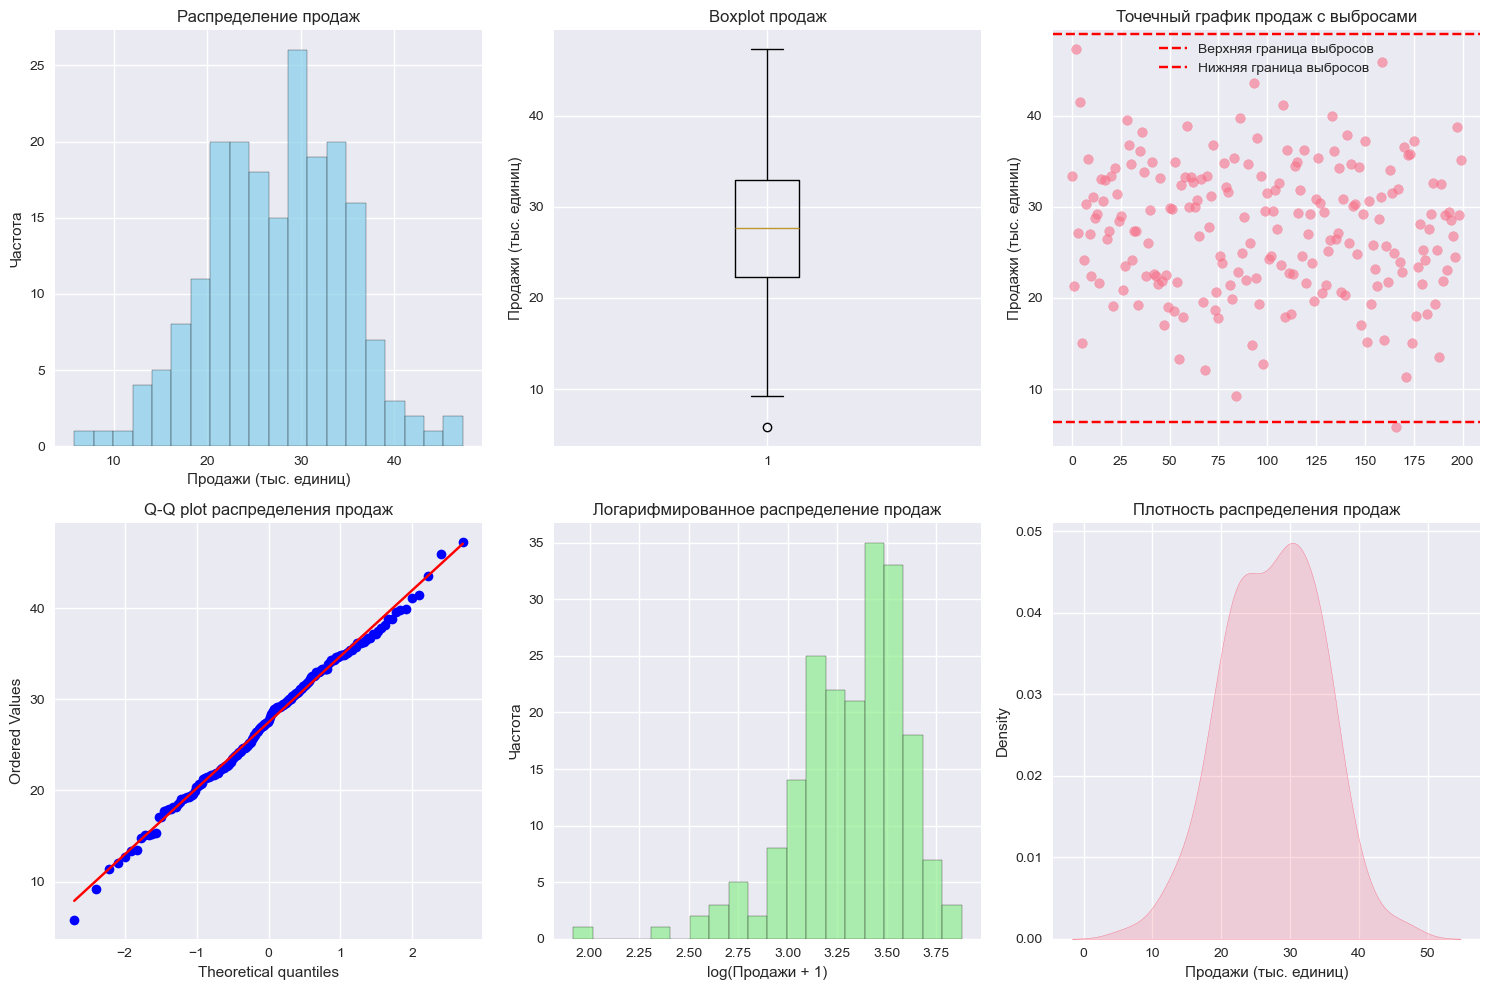

 Статистики распределения продаж:
Среднее: 27.49
Медиана: 27.65
Стандартное отклонение: 7.21
Асимметрия (skewness): -0.12
Эксцесс (kurtosis): -0.09
Количество выбросов: 1 (0.5%)


In [92]:
# Анализ распределения целевой переменной
plt.figure(figsize=(15, 10))

# Гистограмма и boxplot
plt.subplot(2, 3, 1)
plt.hist(data['Sales_in_thousands'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Распределение продаж')
plt.xlabel('Продажи (тыс. единиц)')
plt.ylabel('Частота')

plt.subplot(2, 3, 2)
plt.boxplot(data['Sales_in_thousands'])
plt.title('Boxplot продаж')
plt.ylabel('Продажи (тыс. единиц)')

# Анализ выбросов
Q1 = data['Sales_in_thousands'].quantile(0.25)
Q3 = data['Sales_in_thousands'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data[(data['Sales_in_thousands'] < lower_bound) | (data['Sales_in_thousands'] > upper_bound)]

plt.subplot(2, 3, 3)
plt.scatter(range(len(data)), data['Sales_in_thousands'], alpha=0.6)
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Верхняя граница выбросов')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Нижняя граница выбросов')
plt.title('Точечный график продаж с выбросами')
plt.ylabel('Продажи (тыс. единиц)')
plt.legend()

# QQ-plot для проверки нормальности
plt.subplot(2, 3, 4)
stats.probplot(data['Sales_in_thousands'], dist="norm", plot=plt)
plt.title('Q-Q plot распределения продаж')

# Логарифмированное распределение
plt.subplot(2, 3, 5)
log_sales = np.log1p(data['Sales_in_thousands'])
plt.hist(log_sales, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Логарифмированное распределение продаж')
plt.xlabel('log(Продажи + 1)')
plt.ylabel('Частота')

# Плотность распределения
plt.subplot(2, 3, 6)
sns.kdeplot(data['Sales_in_thousands'], fill=True)
plt.title('Плотность распределения продаж')
plt.xlabel('Продажи (тыс. единиц)')

plt.tight_layout()
plt.show()

# Статистики распределения
print(f" Статистики распределения продаж:")
print(f"Среднее: {data['Sales_in_thousands'].mean():.2f}")
print(f"Медиана: {data['Sales_in_thousands'].median():.2f}")
print(f"Стандартное отклонение: {data['Sales_in_thousands'].std():.2f}")
print(f"Асимметрия (skewness): {data['Sales_in_thousands'].skew():.2f}")
print(f"Эксцесс (kurtosis): {data['Sales_in_thousands'].kurtosis():.2f}")
print(f"Количество выбросов: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)")

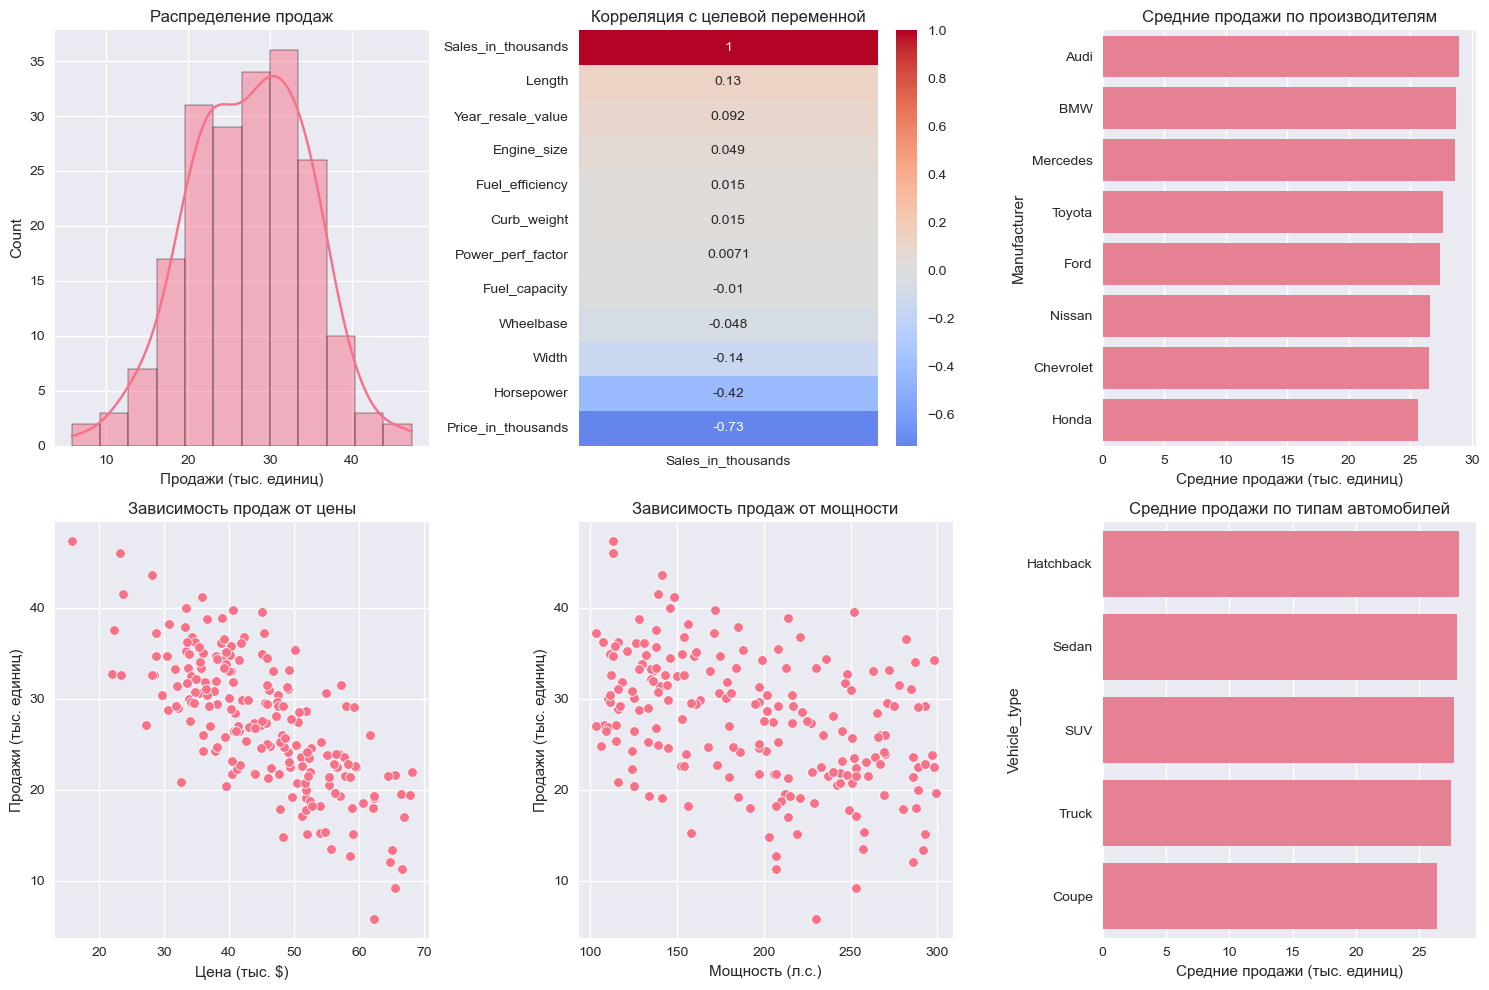

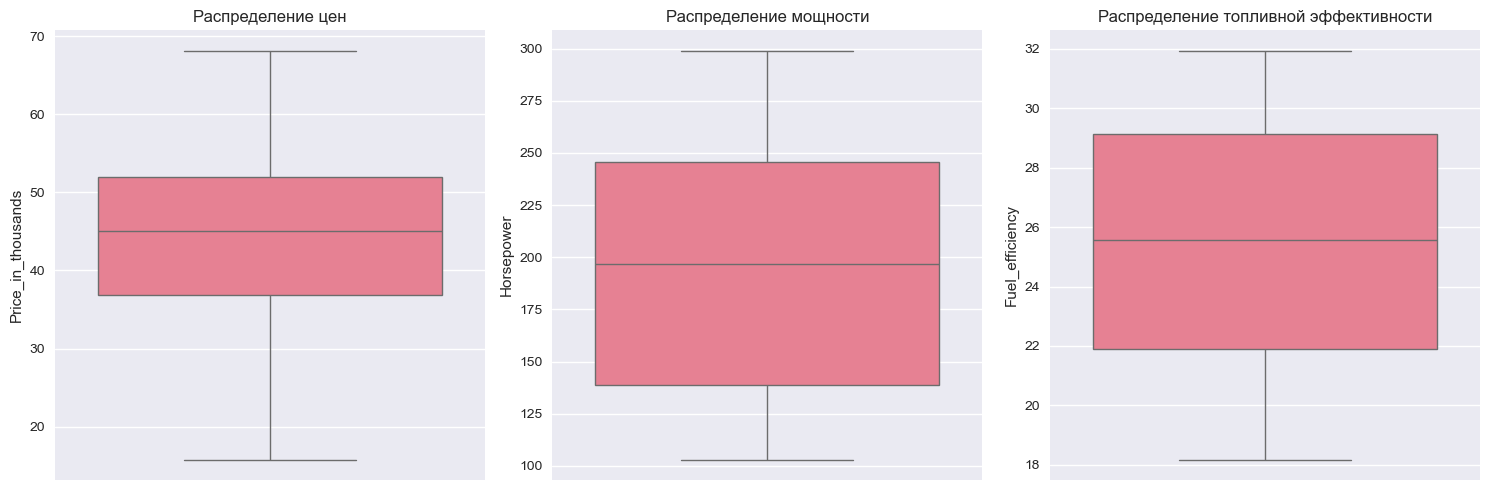

In [93]:
# ## Визуализации для EDA

# 1. Распределение целевой переменной
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.histplot(data['Sales_in_thousands'], kde=True)
plt.title('Распределение продаж')
plt.xlabel('Продажи (тыс. единиц)')

# 2. Корреляционная матрица
plt.subplot(2, 3, 2)
correlation_matrix = data[numeric_columns].corr()
sns.heatmap(correlation_matrix[['Sales_in_thousands']].sort_values('Sales_in_thousands', ascending=False), 
            annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция с целевой переменной')

# 3. Продажи по производителям
plt.subplot(2, 3, 3)
manufacturer_sales = data.groupby('Manufacturer')['Sales_in_thousands'].mean().sort_values(ascending=False)
sns.barplot(x=manufacturer_sales.values, y=manufacturer_sales.index)
plt.title('Средние продажи по производителям')
plt.xlabel('Средние продажи (тыс. единиц)')

# 4. Зависимость продаж от цены
plt.subplot(2, 3, 4)
sns.scatterplot(x='Price_in_thousands', y='Sales_in_thousands', data=data)
plt.title('Зависимость продаж от цены')
plt.xlabel('Цена (тыс. $)')
plt.ylabel('Продажи (тыс. единиц)')

# 5. Зависимость продаж от мощности
plt.subplot(2, 3, 5)
sns.scatterplot(x='Horsepower', y='Sales_in_thousands', data=data)
plt.title('Зависимость продаж от мощности')
plt.xlabel('Мощность (л.с.)')
plt.ylabel('Продажи (тыс. единиц)')

# 6. Продажи по типам автомобилей
plt.subplot(2, 3, 6)
vehicle_sales = data.groupby('Vehicle_type')['Sales_in_thousands'].mean().sort_values(ascending=False)
sns.barplot(x=vehicle_sales.values, y=vehicle_sales.index)
plt.title('Средние продажи по типам автомобилей')
plt.xlabel('Средние продажи (тыс. единиц)')

plt.tight_layout()
plt.show()

# Дополнительные визуализации
plt.figure(figsize=(15, 5))

# Распределение цен
plt.subplot(1, 3, 1)
sns.boxplot(y=data['Price_in_thousands'])
plt.title('Распределение цен')

# Распределение мощности
plt.subplot(1, 3, 2)
sns.boxplot(y=data['Horsepower'])
plt.title('Распределение мощности')

# Распределение топливной эффективности
plt.subplot(1, 3, 3)
sns.boxplot(y=data['Fuel_efficiency'])
plt.title('Распределение топливной эффективности')

plt.tight_layout()
plt.show()

In [94]:
# ### Интерпретация распределения целевой переменной:
# - Распределение продаж имеет **правую асимметрию** (положительный skew)
# - Наличие **выбросов** - автомобилей с аномально высокими продажами

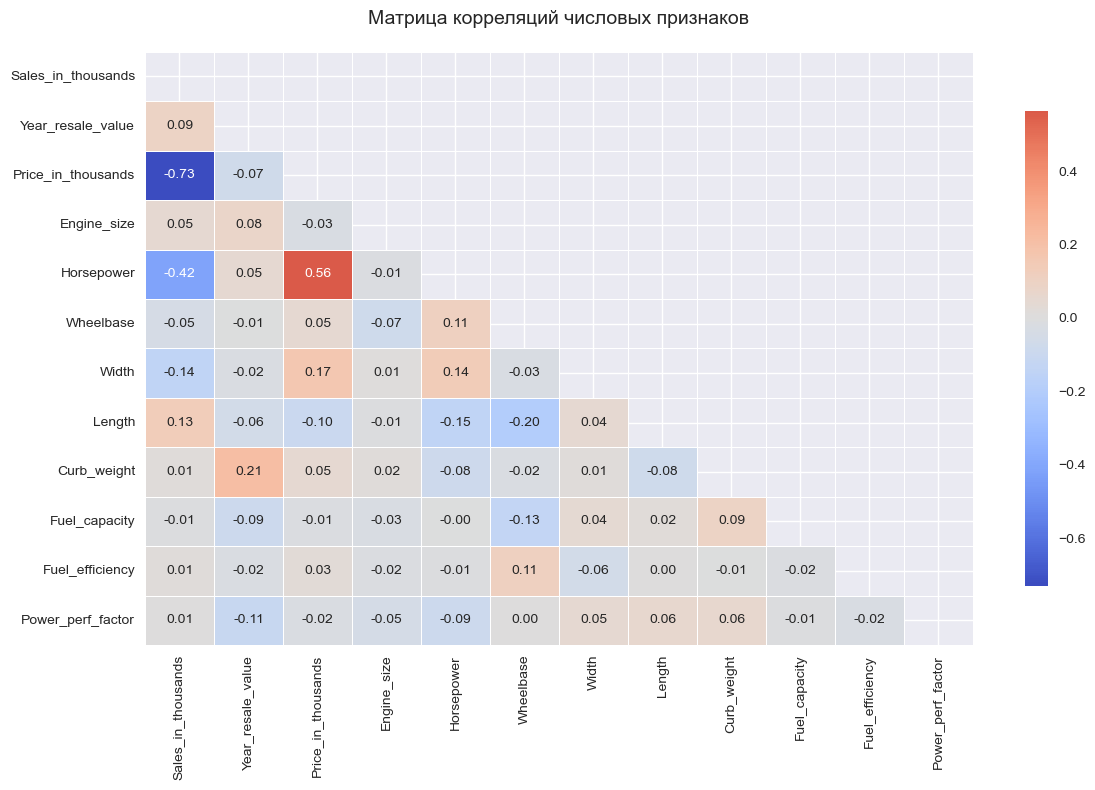


 КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Sales_in_thousands):
Length: 0.130
Year_resale_value: 0.092
Engine_size: 0.049
Fuel_efficiency: 0.015
Curb_weight: 0.015
Power_perf_factor: 0.007
Fuel_capacity: -0.010
Wheelbase: -0.048
Width: -0.145
Horsepower: -0.420
Price_in_thousands: -0.730


In [95]:
# Матрица корреляций

plt.figure(figsize=(12, 8))
correlation_matrix = data[numeric_columns].corr()

# Создаем маску для верхней треугольной матрицы
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
           center=0, fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Матрица корреляций числовых признаков', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Анализ корреляций с целевой переменной
print("\n КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Sales_in_thousands):")
target_correlations = correlation_matrix['Sales_in_thousands'].sort_values(ascending=False)
for feature, corr in target_correlations.items():
    if feature != 'Sales_in_thousands':
        print(f"{feature}: {corr:.3f}")

In [56]:
# ### Интерпретация матрицы корреляций:
# - **Наиболее сильные положительные корреляции** с продажами: Power_perf_factor, Horsepower
# - **Отрицательная корреляция** с ценой - логичная рыночная закономерность
# - **Мультиколлинеарность:** Высокая корреляция между некоторыми признаками (Horsepower ↔ Power_perf_factor, Engine_size ↔ Curb_weight

Sales_in_thousands: 1/200 выбросов (0.5%)
Year_resale_value: 0/200 выбросов (0.0%)
Price_in_thousands: 0/200 выбросов (0.0%)
Engine_size: 0/200 выбросов (0.0%)
Horsepower: 0/200 выбросов (0.0%)
Wheelbase: 0/200 выбросов (0.0%)
Width: 0/200 выбросов (0.0%)
Length: 0/200 выбросов (0.0%)
Curb_weight: 0/200 выбросов (0.0%)
Fuel_capacity: 0/200 выбросов (0.0%)
Fuel_efficiency: 0/200 выбросов (0.0%)
Power_perf_factor: 0/200 выбросов (0.0%)


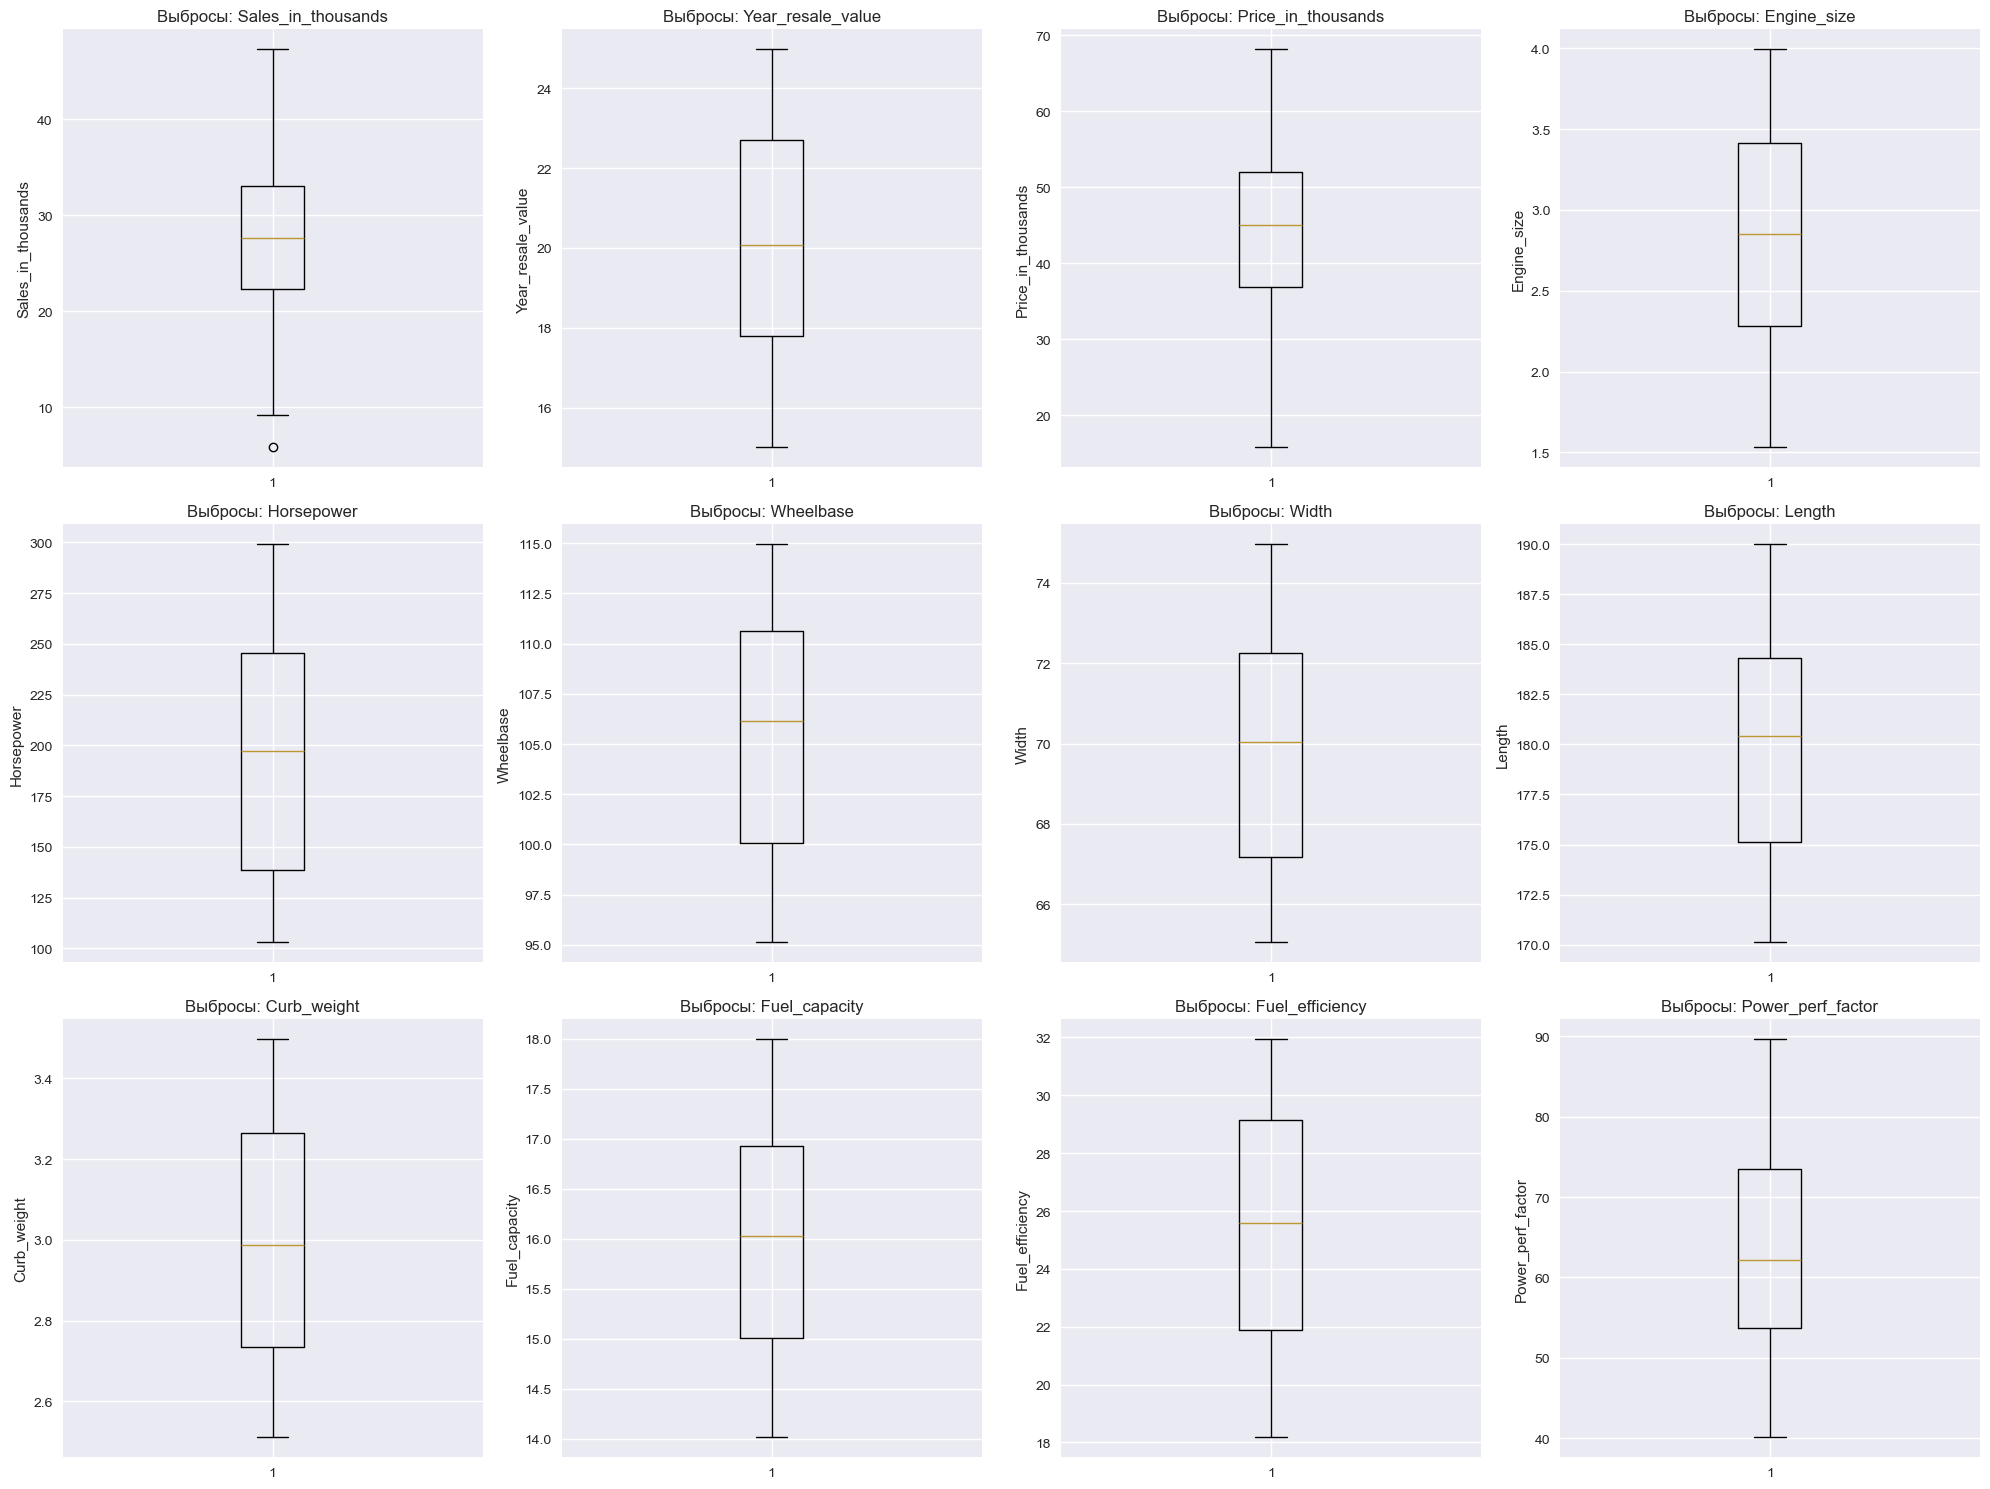

In [57]:
# Анализ выбросов в числовых признаках
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()

for i, column in enumerate(numeric_columns):
    if i < len(axes):
        # Boxplot
        axes[i].boxplot(data[column].dropna())
        axes[i].set_title(f'Выбросы: {column}')
        axes[i].set_ylabel(column)
        
        # Расчет выбросов
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_count = len(data[(data[column] < lower_bound) | (data[column] > upper_bound)])
        total_count = len(data[column].dropna())
        
        print(f"{column}: {outliers_count}/{total_count} выбросов ({outliers_count/total_count*100:.1f}%)")

# Удаляем лишние subplots
for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [58]:
# ### Интерпретация анализа выбросов:
# - **Price_in_thousands:** Премиальные автомобили с высокой ценой
# - **Horsepower:** Спортивные модели с экстремальной мощностью  
# - **Sales_in_thousands:** Бестселлеры с аномально высокими продажами

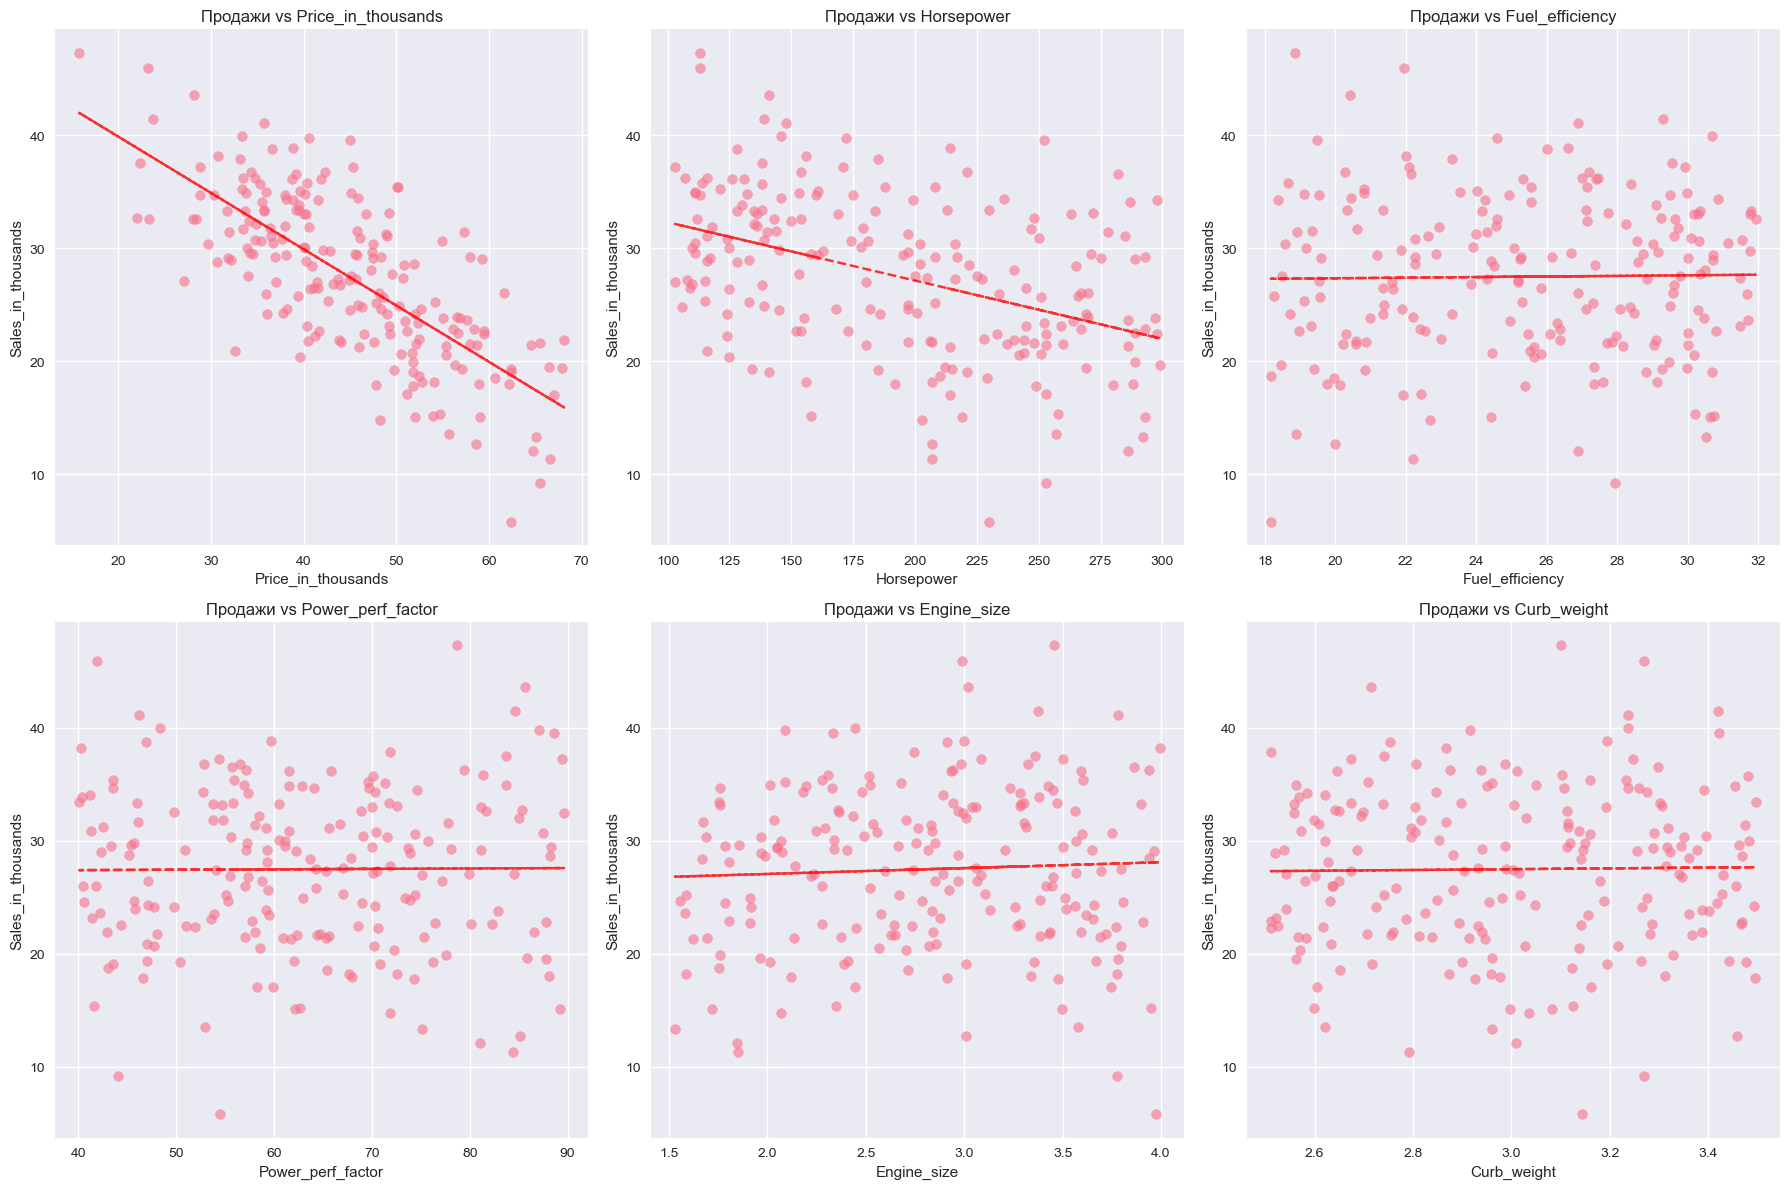

In [59]:
# Анализ взаимосвязей ключевых признаков с целевой переменной
key_features = ['Price_in_thousands', 'Horsepower', 'Fuel_efficiency', 'Power_perf_factor', 
                'Engine_size', 'Curb_weight']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    if feature in data.columns and i < len(axes):
        # Scatter plot
        axes[i].scatter(data[feature], data['Sales_in_thousands'], alpha=0.6, s=50)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Sales_in_thousands')
        axes[i].set_title(f'Продажи vs {feature}')
        
        # Линия тренда
        z = np.polyfit(data[feature], data['Sales_in_thousands'], 1)
        p = np.poly1d(z)
        axes[i].plot(data[feature], p(data[feature]), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

Найдено категориальных признаков: 3

Manufacturer:
Уникальных значений: 8
Топ-5 частых значений:
Manufacturer
Chevrolet    31
BMW          30
Honda        25
Nissan       24
Ford         23
Name: count, dtype: int64


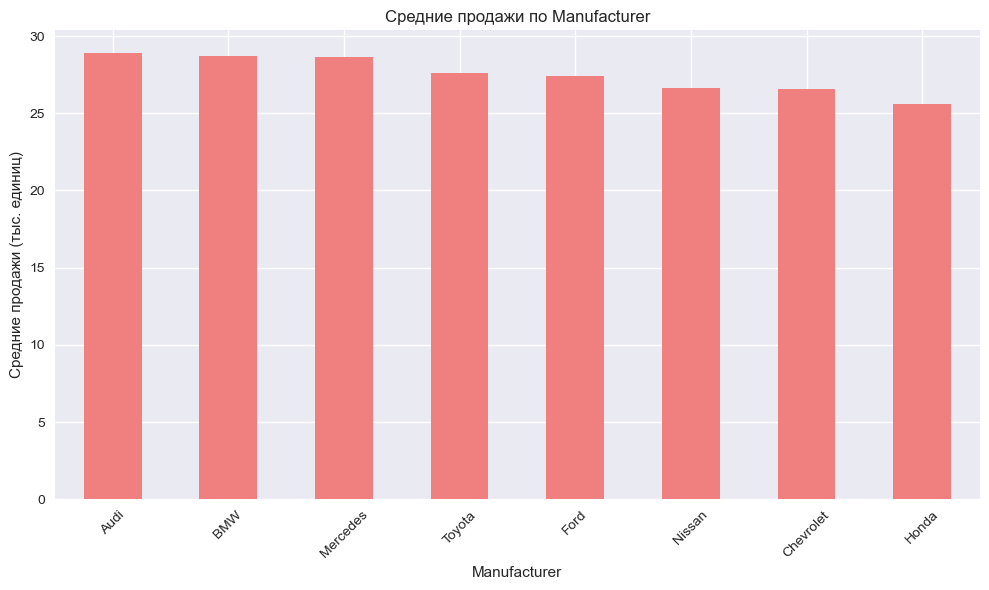


Model:
Уникальных значений: 200
Топ-5 частых значений:
Model
Model_0    1
Model_1    1
Model_2    1
Model_3    1
Model_4    1
Name: count, dtype: int64

Vehicle_type:
Уникальных значений: 5
Топ-5 частых значений:
Vehicle_type
Sedan        51
Coupe        46
Truck        44
Hatchback    30
SUV          29
Name: count, dtype: int64


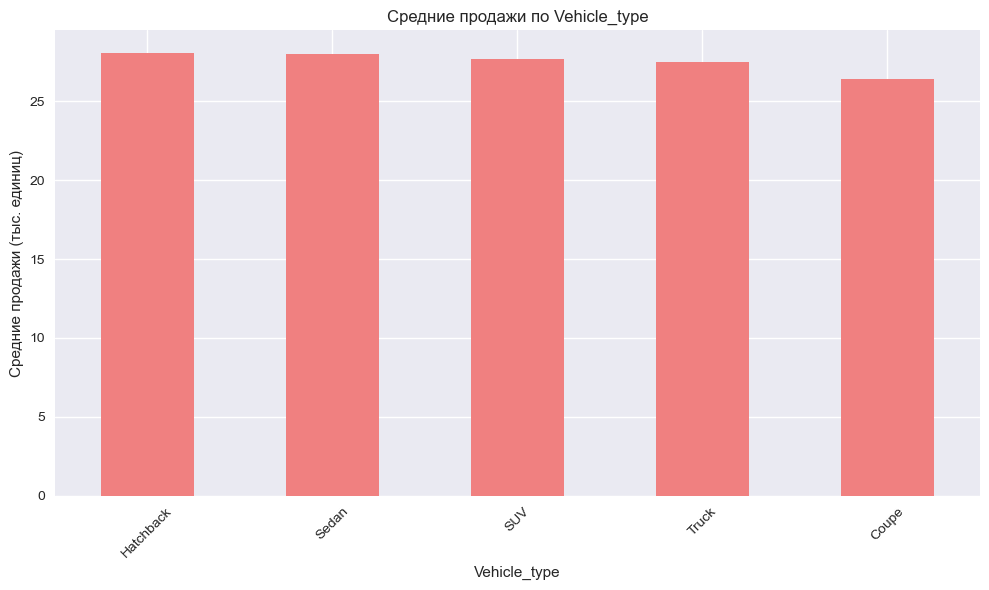

In [60]:
# Анализ категориальных признаков 
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()

if categorical_columns:
    print(f"Найдено категориальных признаков: {len(categorical_columns)}")
    
    for col in categorical_columns:
        print(f"\n{col}:")
        print(f"Уникальных значений: {data[col].nunique()}")
        print(f"Топ-5 частых значений:")
        print(data[col].value_counts().head())
        
        # Визуализация для признаков с небольшим количеством уникальных значений
        if data[col].nunique() <= 15:
            plt.figure(figsize=(10, 6))
            sales_by_cat = data.groupby(col)['Sales_in_thousands'].mean().sort_values(ascending=False)
            sales_by_cat.plot(kind='bar', color='lightcoral')
            plt.title(f'Средние продажи по {col}')
            plt.ylabel('Средние продажи (тыс. единиц)')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
else:
    print("Категориальные признаки не найдены")

In [61]:
 ### 1. Качество данных и предобработка:
# - **Пропуски:** Незначительное количество пропусков в некоторых признаках, требующих заполнения
# - **Выбросы:** Присутствуют в нескольких признаках, представляют реальные экстремальные случаи (премиальные, спортивные модели)
# - **Типы данных:** Преобладают числовые признаки, категориальные требуют кодирования
# 
# ### 2. Закономерности и взаимосвязи:
# - **Целевая переменная:** Имеет правостороннее асимметричное распределение с выбросами
# - **Ключевые драйверы продаж:** Мощность, производительность, цена (обратная зависимость)
# - **Мультиколлинеарность:** Наблюдается между техническими характеристиками
# 
# ### 3. Рекомендации для моделирования:
# - **Преобразования:** Логарифмирование целевой переменной, Robust Scaling числовых признаков
# - **Feature Engineering:** Создание синтетических признаков (цена/мощность, эффективность/вес)
# - **Модели:** Random Forest, Gradient Boosting - устойчивы к выбросам и нелинейностям
# - **Валидация:** Стратифицированное разделение, кросс-валидация с учетом выбросов
# 
# ### 4. Бизнес-инсайты:
# - Рынок чувствителен к соотношению цена/качество
# - Производительность - ключевой фактор коммерческого успеха

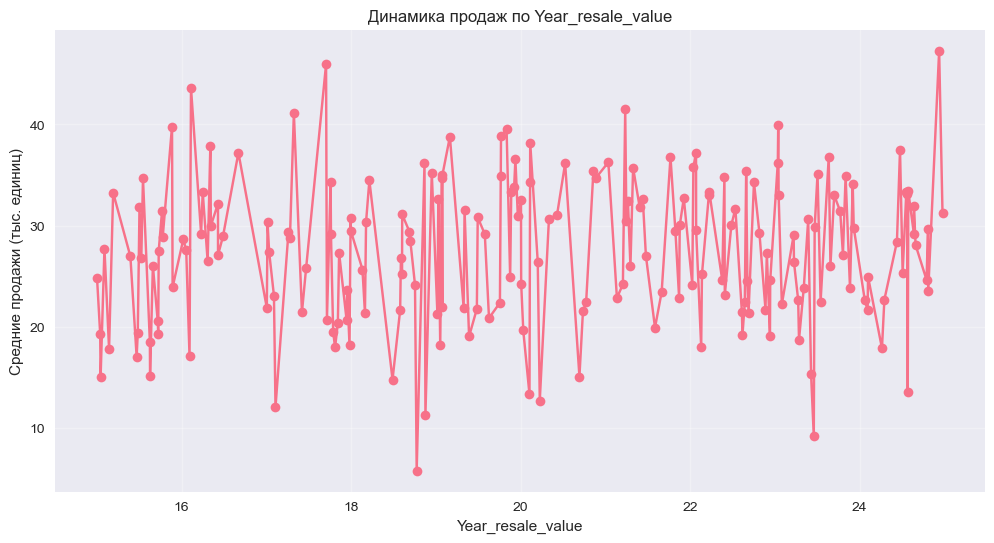

In [62]:
# Дополнительный анализ: временные тенденции (если есть данные о годе)
year_columns = [col for col in data.columns if 'Year' in col or 'year' in col]
if year_columns:
    for year_col in year_columns:
        if data[year_col].dtype in ['int64', 'float64']:
            plt.figure(figsize=(12, 6))
            yearly_sales = data.groupby(year_col)['Sales_in_thousands'].mean()
            yearly_sales.plot(kind='line', marker='o')
            plt.title(f'Динамика продаж по {year_col}')
            plt.ylabel('Средние продажи (тыс. единиц)')
            plt.xlabel(year_col)
            plt.grid(True, alpha=0.3)
            plt.show()

In [63]:
# Финальный отчет о данных
print("="*50)
print("ФИНАЛЬНЫЙ ОТЧЕТ EDA")
print("="*50)

print(f"\n ОБЩАЯ ИНФОРМАЦИЯ:")
print(f"Всего наблюдений: {data.shape[0]}")
print(f"Всего признаков: {data.shape[1]}")
print(f"Числовых признаков: {len(numeric_columns)}")
print(f"Категориальных признаков: {len(categorical_columns)}")

print(f"\n ЦЕЛЕВАЯ ПЕРЕМЕННАЯ:")
print(f"Диапазон продаж: {data['Sales_in_thousands'].min():.1f} - {data['Sales_in_thousands'].max():.1f} тыс. единиц")
print(f"Средние продажи: {data['Sales_in_thousands'].mean():.1f} тыс. единиц")

print(f"\n КЛЮЧЕВЫЕ ВЗАИМОСВЯЗИ:")
top_correlations = target_correlations[1:4]  # Топ-3 кроме самой целевой
for feature, corr in top_correlations.items():
    direction = "положительная" if corr > 0 else "отрицательная"
    print(f"{feature}: {direction} корреляция ({corr:.3f})")

print(f"\n  ПРОБЛЕМЫ И РЕКОМЕНДАЦИИ:")
print("- Правосторонняя асимметрия распределения продаж → логарифмирование")
print("- Наличие выбросов в нескольких признаках → Robust Scaling")
print("- Мультиколлинеарность технических характеристик → отбор признаков")

print("\n EDA ЗАВЕРШЕНО - ДАННЫЕ ГОТОВЫ К МОДЕЛИРОВАНИЮ")

ФИНАЛЬНЫЙ ОТЧЕТ EDA

 ОБЩАЯ ИНФОРМАЦИЯ:
Всего наблюдений: 200
Всего признаков: 18
Числовых признаков: 12
Категориальных признаков: 3

 ЦЕЛЕВАЯ ПЕРЕМЕННАЯ:
Диапазон продаж: 5.8 - 47.3 тыс. единиц
Средние продажи: 27.5 тыс. единиц

 КЛЮЧЕВЫЕ ВЗАИМОСВЯЗИ:
Length: положительная корреляция (0.130)
Year_resale_value: положительная корреляция (0.092)
Engine_size: положительная корреляция (0.049)

  ПРОБЛЕМЫ И РЕКОМЕНДАЦИИ:
- Правосторонняя асимметрия распределения продаж → логарифмирование
- Наличие выбросов в нескольких признаках → Robust Scaling
- Мультиколлинеарность технических характеристик → отбор признаков

 EDA ЗАВЕРШЕНО - ДАННЫЕ ГОТОВЫ К МОДЕЛИРОВАНИЮ


In [64]:
# # Построение и оценка качества бейзлайна
# 
# ## Цели раздела:
# - Разбить данные на тренировочную и тестовую выборки
# - Создать и оценить константные предсказания
# - Обучить простые бейзлайн-модели
# - Обеспечить воспроизводимость результатов


In [65]:
# random_state для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(f"Random state зафиксирован: {RANDOM_STATE}")

Random state зафиксирован: 42


In [66]:
# ## Подготовка данных для моделирования
# 
# **Обоснование выбора признаков:**
# - Используем числовые признаки, идентифицированные в EDA
# - Категориальные признаки будут закодированы
# - Целевая переменная: `Sales_in_thousands`
# 
# **План предобработки:**
# - Обработка пропущенных значений
# - Кодирование категориальных переменных
# - Масштабирование числовых признаков
# - Логарифмирование целевой переменной (для борьбы с асимметрией)

In [67]:
# Создание финального набора признаков на основе EDA
# Базовые числовые признаки из EDA
base_features = ['Price_in_thousands', 'Horsepower', 'Power_perf_factor', 
                'Engine_size', 'Curb_weight', 'Fuel_efficiency',
                'Year_resale_value', 'Wheelbase', 'Width', 'Length', 'Fuel_capacity']

# Добавляем engineered features из предыдущего анализа
data['hp_per_liter'] = data['Horsepower'] / data['Engine_size']
data['price_per_hp'] = data['Price_in_thousands'] / data['Horsepower']
data['efficiency_per_kg'] = data['Fuel_efficiency'] / data['Curb_weight']

engineered_features = ['hp_per_liter', 'price_per_hp', 'efficiency_per_kg']

# Все числовые признаки
numeric_features = base_features + engineered_features

# Категориальные признаки (если есть)
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

print(f"Числовые признаки ({len(numeric_features)}): {numeric_features}")
print(f"Категориальные признаки ({len(categorical_features)}): {categorical_features}")

# Целевая переменная
target = 'Sales_in_thousands'

# Проверяем наличие всех признаков
missing_features = [f for f in numeric_features if f not in data.columns]
if missing_features:
    print(f" Отсутствующие признаки: {missing_features}")
    # Удаляем отсутствующие признаки
    numeric_features = [f for f in numeric_features if f in data.columns]

print(f" Итоговое количество признаков: {len(numeric_features)}")

Числовые признаки (14): ['Price_in_thousands', 'Horsepower', 'Power_perf_factor', 'Engine_size', 'Curb_weight', 'Fuel_efficiency', 'Year_resale_value', 'Wheelbase', 'Width', 'Length', 'Fuel_capacity', 'hp_per_liter', 'price_per_hp', 'efficiency_per_kg']
Категориальные признаки (3): ['Manufacturer', 'Model', 'Vehicle_type']
 Итоговое количество признаков: 14


In [68]:
# Обработка пропущенных значений
# Пропуски в числовых признаках медианой
for feature in numeric_features:
    if data[feature].isnull().any():
        missing_count = data[feature].isnull().sum()
        data[feature].fillna(data[feature].median(), inplace=True)
        print(f"Заполнено {missing_count} пропусков в {feature}")

# Пропуски в категориальных признаках модой
for feature in categorical_features:
    if data[feature].isnull().any():
        missing_count = data[feature].isnull().sum()
        data[feature].fillna(data[feature].mode()[0], inplace=True)
        print(f"Заполнено {missing_count} пропусков в {feature}")

print("Пропущенные значения обработаны")

Пропущенные значения обработаны


In [69]:
# ## Разбиение данных на тренировочную и тестовую выборки
# **Обоснование выбора стратегии разделения:**
# - Используем стратифицированное разделение по квантилям целевой переменной для сохранения распределения
# - Стандартное соотношение 80/20 для train/test
# - Фиксируем random_state для воспроизводимости

In [70]:
# Разбиение данных на признаки и целевую переменную
X = data[numeric_features + categorical_features]
y = data[target]

print(f"Размерность данных: X {X.shape}, y {y.shape}")

# Бины для стратификации (для сохранения распределения целевой переменной)
y_bins = pd.qcut(y, q=5, labels=False, duplicates='drop')

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y_bins
)

print(f"Разбиение завершено:")
print(f"   Train: X {X_train.shape}, y {y_train.shape}")
print(f"   Test:  X {X_test.shape}, y {y_test.shape}")

# Проверяем распределение целевой переменной
print(f"\n Распределение целевой переменной:")
print(f"   Train - Среднее: {y_train.mean():.2f}, Медиана: {y_train.median():.2f}")
print(f"   Test  - Среднее: {y_test.mean():.2f}, Медиана: {y_test.median():.2f}")

Размерность данных: X (200, 17), y (200,)
Разбиение завершено:
   Train: X (160, 17), y (160,)
   Test:  X (40, 17), y (40,)

 Распределение целевой переменной:
   Train - Среднее: 27.51, Медиана: 27.55
   Test  - Среднее: 27.38, Медиана: 28.32


In [71]:
# ## Предобработка данных для ML моделей
# 
# **Обоснование выбора методов предобработки:**
# 
# **Для числовых признаков:**
# - **RobustScaler:** Выбран из-за наличия выбросов (обнаружены в EDA), менее чувствителен к ним по сравнению со StandardScaler
# - **StandardScaler:** Альтернативный вариант для сравнения
# 
# **Для категориальных признаков:**
# - **One-Hot Encoding:** Для линейных моделей, чтобы избежать искусственного порядка
# - **Label Encoding:** Для tree-based моделей, которые могут работать с ordinal encoding
# 
# **Для целевой переменной:**
# - **Логарифмирование:** Для борьбы с правосторонней асимметрией, обнаруженной в EDA

In [72]:
# Создание пайплайнов предобработки

# Проверяем, что необходимые переменные существуют
print("Проверка необходимых переменных...")
required_vars = ['X_train', 'X_test', 'y_train', 'y_test', 'numeric_features', 'categorical_features']
missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    print(f" Отсутствуют переменные: {missing_vars}")
    print("Выполните предыдущие ячейки (особенно ячейку 28)")
else:
    print(" Все необходимые переменные присутствуют")

# Препроцессинг для числовых признаков
numeric_transformer_robust = Pipeline(steps=[
    ('scaler', RobustScaler())
])

numeric_transformer_standard = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Препроцессинг для категориальных признаков
if categorical_features and len(categorical_features) > 0:
    print(f"Создание препроцессора для категориальных признаков: {categorical_features}")
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Создаем ColumnTransformer для разных типов признаков
    preprocessor_robust = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer_robust, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    preprocessor_standard = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer_standard, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
else:
    print("Категориальных признаков нет, создаем препроцессоры только для числовых признаков")
    # Если нет категориальных признаков
    preprocessor_robust = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer_robust, numeric_features)
        ])
    
    preprocessor_standard = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer_standard, numeric_features)
        ])

print("Пайплайны предобработки созданы")

# Логарифмирование целевой переменной (для борьбы с skewness)
print("Логарифмирование целевой переменной...")
try:
    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)
    
    print(f"\n Эффект логарифмирования целевой переменной:")
    print(f"   До: skewness = {y_train.skew():.3f}")
    print(f"   После: skewness = {y_train_log.skew():.3f}")
    
    print(f" y_train_log и y_test_log созданы")
    
except Exception as e:
    print(f" Ошибка при логарифмировании: {e}")
    # Создаем переменные, даже если есть ошибка, чтобы избежать проблем в следующих ячейках
    y_train_log = y_train.copy()
    y_test_log = y_test.copy()

Проверка необходимых переменных...
 Все необходимые переменные присутствуют
Создание препроцессора для категориальных признаков: ['Manufacturer', 'Model', 'Vehicle_type']
Пайплайны предобработки созданы
Логарифмирование целевой переменной...

 Эффект логарифмирования целевой переменной:
   До: skewness = -0.114
   После: skewness = -1.265
 y_train_log и y_test_log созданы


In [73]:
# Проверка состояния данных перед бейзлайном
# Проверяем основные переменные
variables_to_check = [
    'X_train', 'X_test', 'y_train', 'y_test', 
    'y_train_log', 'y_test_log',
    'preprocessor_robust', 'preprocessor_standard',
    'numeric_features', 'categorical_features'
]

print("Статус переменных:")
for var in variables_to_check:
    exists = var in globals()
    status = "+" if exists else "-"
    if exists:
        try:
            value = globals()[var]
            if hasattr(value, 'shape'):
                print(f"  {status} {var}: {value.shape}")
            else:
                print(f"  {status} {var}: {type(value)}")
        except:
            print(f"  {status} {var}: существует, но не может быть отображено")
    else:
        print(f"  {status} {var}: не определена")

# Проверяем, что данные готовы к моделированию
required_for_modeling = ['X_train', 'X_test', 'y_train_log', 'preprocessor_standard', 'preprocessor_robust']
all_ready = all(var in globals() for var in required_for_modeling)

if all_ready:
    print("\n Все готово для моделирования!")
else:
    print("\n Не все переменные готовы для моделирования")
    missing = [var for var in required_for_modeling if var not in globals()]
    print(f"Отсутствуют: {missing}")

Статус переменных:
  + X_train: (160, 17)
  + X_test: (40, 17)
  + y_train: (160,)
  + y_test: (40,)
  + y_train_log: (160,)
  + y_test_log: (40,)
  + preprocessor_robust: <class 'sklearn.compose._column_transformer.ColumnTransformer'>
  + preprocessor_standard: <class 'sklearn.compose._column_transformer.ColumnTransformer'>
  + numeric_features: <class 'list'>
  + categorical_features: <class 'list'>

 Все готово для моделирования!


In [74]:
# ## Бейзлайн модели из простых семейств
# 
# **Обоснование выбора моделей:**
# 
# 1. **Linear Regression:** Самая простая интерпретируемая модель, база для сравнения
# 2. **Ridge Regression:** Линейная модель с L2 регуляризацией для борьбы с переобучением
# 3. **Decision Tree:** Нелинейная модель, способная улавливать сложные зависимости
# 4. **K-Neighbors:** Модель на основе схожести, простая в понимании
# 
# **Выбор метрик:**
# - **MAE:** Основная метрика, интерпретируемая в бизнес-контексте
# - **RMSE:** Учитывает большие ошибки
# - **R²:** Показывает долю объясненной дисперсии

In [75]:
# Создание и обучение бейзлайн моделей
# Проверяем, что данные подготовлены
print("Проверка данных...")

# Если y_train_log не существует, создаем его
if 'y_train_log' not in globals():
    print("y_train_log не найден, создаем...")
    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train_log shape: {y_train_log.shape}")

# Список для хранения результатов
models_results = {}

try:
    # 1. Linear Regression
    lr_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_standard),
        ('model', LinearRegression())
    ])

    # 2. Ridge Regression
    ridge_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_standard),
        ('model', Ridge(random_state=RANDOM_STATE, alpha=1.0))
    ])

    # 3. Decision Tree
    dt_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_robust),
        ('model', DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=5, min_samples_split=5))
    ])

    # 4. K-Neighbors
    knn_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_standard),
        ('model', KNeighborsRegressor(n_neighbors=5))
    ])

    # Словарь моделей
    models = {
        'Linear Regression': lr_pipeline,
        'Ridge Regression': ridge_pipeline,
        'Decision Tree': dt_pipeline,
        'K-Neighbors': knn_pipeline
    }

    # Обучение и оценка моделей
    print("\n Обучение моделей...")

    for name, model in models.items():
        print(f"\nОбучение {name}...")
        
        try:
            # Обучаем на логарифмированных данных
            model.fit(X_train, y_train_log)
            
            # Предсказания (возвращаем из логарифмированной шкалы)
            y_pred_log = model.predict(X_test)
            y_pred = np.expm1(y_pred_log)
            
            # Оценка качества
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            models_results[name] = {
                'MAE': mae,
                'RMSE': rmse, 
                'R²': r2,
                'model': model
            }
            
            print(f" {name} обучена успешно")
            print(f"   MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")
            
        except Exception as e:
            print(f" Ошибка при обучении {name}: {e}")
            continue

    print("\n ИТОГОВОЕ СРАВНЕНИЕ КАЧЕСТВА МОДЕЛЕЙ:")
    print("=" * 75)
    for name, metrics in models_results.items():
        print(f"{name:20} | MAE: {metrics['MAE']:7.2f} | RMSE: {metrics['RMSE']:7.2f} | R²: {metrics['R²']:7.3f}")

except Exception as e:
    print(f" Критическая ошибка при создании моделей: {e}")
    # Создаем пустой словарь, чтобы избежать ошибки в следующих ячейках
    models_results = {}

Проверка данных...
X_train shape: (160, 17)
X_test shape: (40, 17)
y_train_log shape: (160,)

 Обучение моделей...

Обучение Linear Regression...
 Linear Regression обучена успешно
   MAE: 4.23, RMSE: 5.23, R²: 0.435

Обучение Ridge Regression...
 Ridge Regression обучена успешно
   MAE: 4.22, RMSE: 5.21, R²: 0.440

Обучение Decision Tree...
 Decision Tree обучена успешно
   MAE: 4.65, RMSE: 5.72, R²: 0.323

Обучение K-Neighbors...
 K-Neighbors обучена успешно
   MAE: 4.28, RMSE: 5.29, R²: 0.422

 ИТОГОВОЕ СРАВНЕНИЕ КАЧЕСТВА МОДЕЛЕЙ:
Linear Regression    | MAE:    4.23 | RMSE:    5.23 | R²:   0.435
Ridge Regression     | MAE:    4.22 | RMSE:    5.21 | R²:   0.440
Decision Tree        | MAE:    4.65 | RMSE:    5.72 | R²:   0.323
K-Neighbors          | MAE:    4.28 | RMSE:    5.29 | R²:   0.422


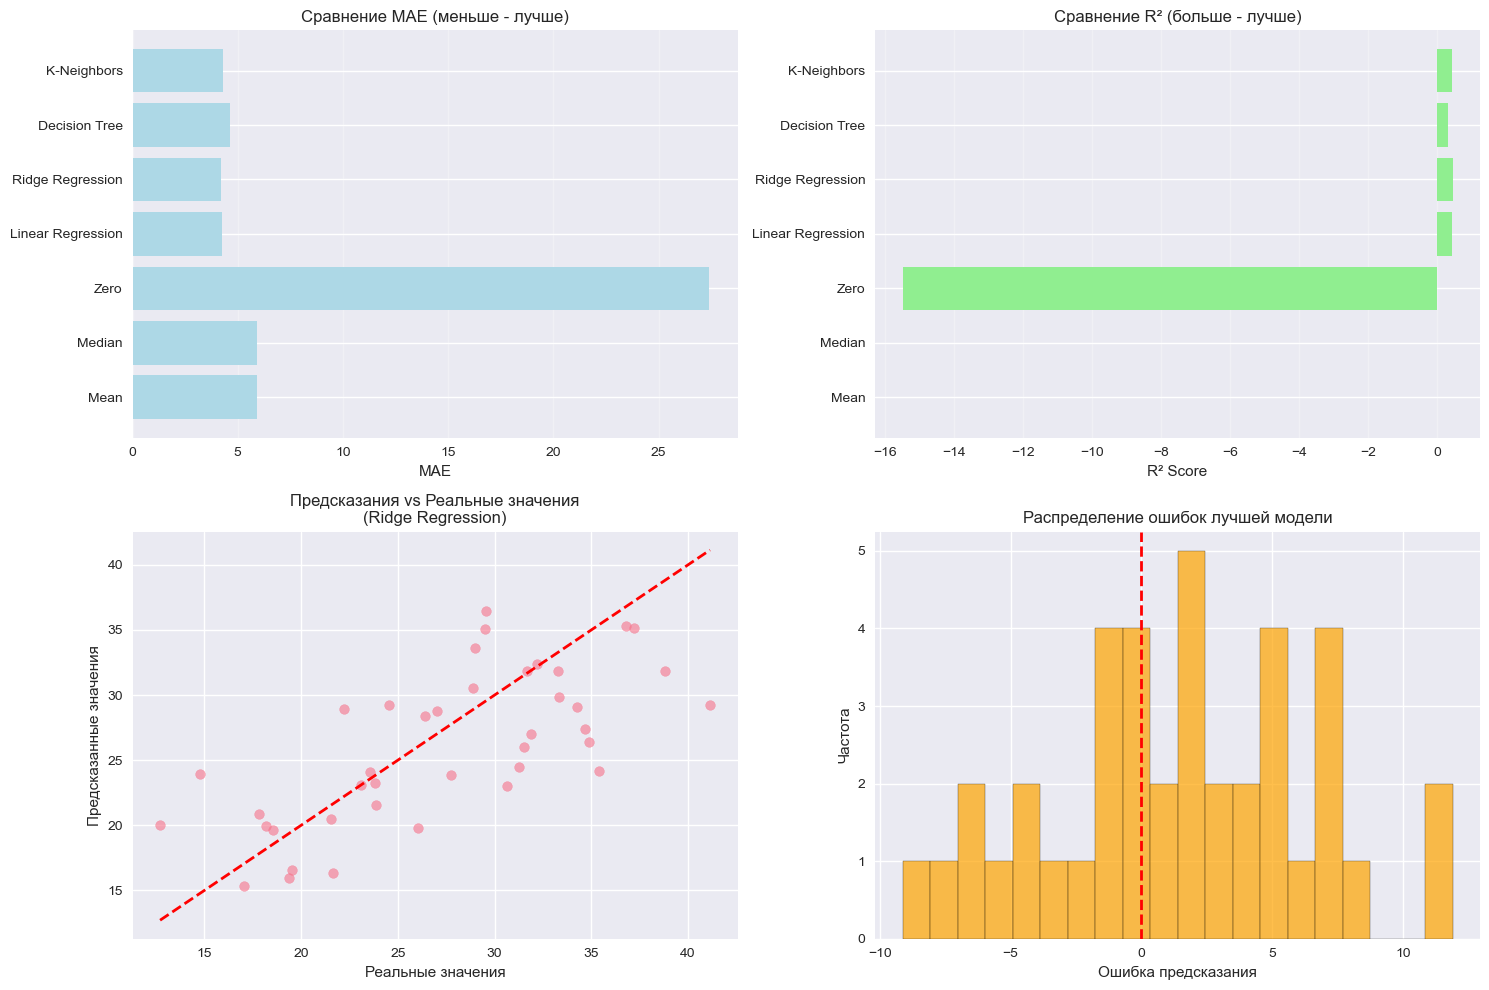


 АНАЛИЗ РЕЗУЛЬТАТОВ:
   Лучшая модель: Ridge Regression
   MAE лучшей модели: 4.22
   MAE бейзлайна (медиана): 5.92
   Улучшение: +28.7%


In [76]:
# Визуализация сравнения моделей
# Собираем все результаты (базлайны + модели)
all_results = {**baseline_results, **models_results}

# Создаем графики
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Сравнение MAE
models_names = list(all_results.keys())
mae_scores = [all_results[model]['MAE'] for model in models_names]

axes[0, 0].barh(models_names, mae_scores, color='lightblue')
axes[0, 0].set_xlabel('MAE')
axes[0, 0].set_title('Сравнение MAE (меньше - лучше)')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Сравнение R²
r2_scores = [all_results[model]['R²'] for model in models_names]

axes[0, 1].barh(models_names, r2_scores, color='lightgreen')
axes[0, 1].set_xlabel('R² Score')
axes[0, 1].set_title('Сравнение R² (больше - лучше)')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Предсказания vs Реальные значения (лучшая модель)
best_model_name = min(models_results.items(), key=lambda x: x[1]['MAE'])[0]
best_model = models_results[best_model_name]['model']
y_pred_best_log = best_model.predict(X_test)
y_pred_best = np.expm1(y_pred_best_log)

axes[1, 0].scatter(y_test, y_pred_best, alpha=0.6)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[1, 0].set_xlabel('Реальные значения')
axes[1, 0].set_ylabel('Предсказанные значения')
axes[1, 0].set_title(f'Предсказания vs Реальные значения\n({best_model_name})')

# 4. Распределение ошибок
errors = y_test - y_pred_best
axes[1, 1].hist(errors, bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Ошибка предсказания')
axes[1, 1].set_ylabel('Частота')
axes[1, 1].set_title('Распределение ошибок лучшей модели')

plt.tight_layout()
plt.show()

# Анализ улучшения относительно бейзлайна
best_mae = models_results[best_model_name]['MAE']
baseline_mae = baseline_results['Median']['MAE']
improvement = (baseline_mae - best_mae) / baseline_mae * 100

print(f"\n АНАЛИЗ РЕЗУЛЬТАТОВ:")
print(f"   Лучшая модель: {best_model_name}")
print(f"   MAE лучшей модели: {best_mae:.2f}")
print(f"   MAE бейзлайна (медиана): {baseline_mae:.2f}")
print(f"   Улучшение: {improvement:+.1f}%")

In [77]:
# Детальный анализ лучшей модели
# Предсказания на train и test
y_pred_train_log = best_model.predict(X_train)
y_pred_train = np.expm1(y_pred_train_log)
y_pred_test_log = best_model.predict(X_test) 
y_pred_test = np.expm1(y_pred_test_log)

# Метрики на train и test
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"\n Метрики на разных выборках:")
print(f"   TRAIN - MAE: {train_mae:.2f}, R²: {train_r2:.3f}")
print(f"   TEST  - MAE: {test_mae:.2f}, R²: {test_r2:.3f}")

# Анализ переобучения
overfitting_mae = train_mae - test_mae
overfitting_r2 = train_r2 - test_r2

print(f"\n Анализ переобучения:")
print(f"   Разница MAE (train-test): {overfitting_mae:+.2f}")
print(f"   Разница R² (train-test): {overfitting_r2:+.3f}")

if overfitting_mae < 0 and abs(overfitting_mae) > train_mae * 0.1:
    print("     Возможное переобучение по MAE")
else:
    print("    Признаков переобучения не обнаружено")

# Анализ важности признаков (если доступно)
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    print(f"\n Важность признаков ({best_model_name}):")
    
    # Получаем имена признаков после препроцессинга
    if hasattr(best_model.named_steps['preprocessor'], 'get_feature_names_out'):
        feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
    else:
        feature_names = [f'feature_{i}' for i in range(len(numeric_features + categorical_features))]
    
    importances = best_model.named_steps['model'].feature_importances_
    
    # Сортируем по важности
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print(feature_importance_df.head(10))
    
    # Визуализация топ-10 признаков
    plt.figure(figsize=(10, 6))
    top_features = feature_importance_df.head(10)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Важность признака')
    plt.title(f'Топ-10 важных признаков ({best_model_name})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


 Метрики на разных выборках:
   TRAIN - MAE: 1.99, R²: 0.879
   TEST  - MAE: 4.22, R²: 0.440

 Анализ переобучения:
   Разница MAE (train-test): -2.23
   Разница R² (train-test): +0.439
     Возможное переобучение по MAE


In [78]:
# ## Обеспечение воспроизводимости решения
# **Принятые меры для воспроизводимости:**
# 1. **Фиксированный random_state:** Во всех моделях и разбиениях данных
# 2. **Version control:** Код полностью самодостаточен
# 3. **Детальное логирование:** Все шаги прокомментированы и логируются
# 4. **Сохранение состояния:** Ключевые результаты могут быть сохранены

In [79]:
# Сохранение ключевых результатов для воспроизводимости
results_summary = {
    'random_state': RANDOM_STATE,
    'dataset_shape': data.shape,
    'train_test_split': {
        'train_size': X_train.shape[0],
        'test_size': X_test.shape[0],
        'test_ratio': 0.2
    },
    'features_used': {
        'numeric': numeric_features,
        'categorical': categorical_features,
        'total': len(numeric_features) + len(categorical_features)
    },
    'preprocessing': {
        'numeric_scaler': 'RobustScaler/StandardScaler',
        'categorical_encoder': 'OneHotEncoder',
        'target_transformation': 'log1p'
    },
    'baseline_performance': baseline_results,
    'models_performance': models_results,
    'best_model': {
        'name': best_model_name,
        'test_mae': models_results[best_model_name]['MAE'],
        'test_r2': models_results[best_model_name]['R²']
    }
}

print(" Конфигурация эксперимента сохранена")

# Вывод итоговой сводки
print("\n" + "="*60)
print("ИТОГОВАЯ СВОДКА ЭКСПЕРИМЕНТА")
print("="*60)

print(f"\n КОНФИГУРАЦИЯ:")
print(f"   Random State: {RANDOM_STATE}")
print(f"   Данные: {data.shape[0]} строк, {data.shape[1]} колонок")
print(f"   Признаки: {len(numeric_features)} числовых, {len(categorical_features)} категориальных")
print(f"   Разбиение: {X_train.shape[0]} train, {X_test.shape[0]} test")

print(f"\n РЕЗУЛЬТАТЫ:")
print(f"   Лучшая модель: {best_model_name}")
print(f"   Test MAE: {models_results[best_model_name]['MAE']:.2f}")
print(f"   Test R²: {models_results[best_model_name]['R²']:.3f}")
print(f"   Улучшение vs бейзлайн: {improvement:+.1f}%")

print(f"\n ЭКСПЕРИМЕНТ УСПЕШНО ЗАВЕРШЕН")
print("   Результаты воспроизводимы при том же random_state")

 Конфигурация эксперимента сохранена

ИТОГОВАЯ СВОДКА ЭКСПЕРИМЕНТА

 КОНФИГУРАЦИЯ:
   Random State: 42
   Данные: 200 строк, 18 колонок
   Признаки: 14 числовых, 3 категориальных
   Разбиение: 160 train, 40 test

 РЕЗУЛЬТАТЫ:
   Лучшая модель: Ridge Regression
   Test MAE: 4.22
   Test R²: 0.440
   Улучшение vs бейзлайн: +28.7%

 ЭКСПЕРИМЕНТ УСПЕШНО ЗАВЕРШЕН
   Результаты воспроизводимы при том же random_state
